# 311 Data

This notebook provides examples for opening and exploring data from NYC's 311 dataset: [311 Service Requests from 2020 to Present](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2020-to-Present/erm2-nwe9/about_data). The data dictionary or codebook describing its variables is available at that main page. You should review it to know what variables are available to you.

NYC gets a lot of 311 calls, and you will need to [query the dataset](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2020-to-Present/erm2-nwe9/explore/query/SELECT%0A%20%20%60unique_key%60%2C%0A%20%20%60created_date%60%2C%0A%20%20%60closed_date%60%2C%0A%20%20%60agency%60%2C%0A%20%20%60agency_name%60%2C%0A%20%20%60complaint_type%60%2C%0A%20%20%60descriptor%60%2C%0A%20%20%60descriptor_2%60%2C%0A%20%20%60location_type%60%2C%0A%20%20%60incident_zip%60%2C%0A%20%20%60incident_address%60%2C%0A%20%20%60street_name%60%2C%0A%20%20%60cross_street_1%60%2C%0A%20%20%60cross_street_2%60%2C%0A%20%20%60intersection_street_1%60%2C%0A%20%20%60intersection_street_2%60%2C%0A%20%20%60address_type%60%2C%0A%20%20%60city%60%2C%0A%20%20%60landmark%60%2C%0A%20%20%60facility_type%60%2C%0A%20%20%60status%60%2C%0A%20%20%60due_date%60%2C%0A%20%20%60resolution_description%60%2C%0A%20%20%60resolution_action_updated_date%60%2C%0A%20%20%60community_board%60%2C%0A%20%20%60council_district%60%2C%0A%20%20%60police_precinct%60%2C%0A%20%20%60bbl%60%2C%0A%20%20%60borough%60%2C%0A%20%20%60x_coordinate_state_plane%60%2C%0A%20%20%60y_coordinate_state_plane%60%2C%0A%20%20%60open_data_channel_type%60%2C%0A%20%20%60park_facility_name%60%2C%0A%20%20%60park_borough%60%2C%0A%20%20%60vehicle_type%60%2C%0A%20%20%60taxi_company_borough%60%2C%0A%20%20%60taxi_pick_up_location%60%2C%0A%20%20%60bridge_highway_name%60%2C%0A%20%20%60bridge_highway_direction%60%2C%0A%20%20%60road_ramp%60%2C%0A%20%20%60bridge_highway_segment%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%2C%0A%20%20%60location%60%0AORDER%20BY%20%60created_date%60%20DESC%20NULL%20FIRST/page/filter) to get an appropriate subsample for your project. 

This notebook will work on *Option 3: Response Time Disparities* from the Readymade Data Module Assignment. 

## Load modules

Like usual, we start by loading the Python modules we'll need later in the notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

I know that Jupyter Notebook can truncate output sometimes, and I don't want it to. So I'm going to use some `pandas` options to change the output for the whole notebook.

In [2]:
pd.set_option('display.max_rows', None) # show all rows in the output
pd.set_option('display.max_columns', None) # show all columns in the output

## Define Helper Functions

We have some functions from earlier in the term that will help me make reports. Let's reuse them here.

In [129]:
# function for generating an APA-style report for a statsmodels regression result
def apa_report(model):
    """
    Generate an APA-style report for a statsmodels regression result.
    Works with arbitrary numbers of predictors.
    """
    # Basic model info
    dep_var = model.model.endog_names
    exog_names = model.model.exog_names  # includes intercept (often 'const')
    params = model.params
    tvalues = model.tvalues
    pvalues = model.pvalues
    ses = model.bse

    r_squared = model.rsquared
    f_value = model.fvalue
    df_model = int(model.df_model)
    df_resid = int(model.df_resid)
    f_pvalue = model.f_pvalue

    # Identify predictors (exclude intercept if present)
    # Common names for intercept are 'const' or 'Intercept'
    intercept_names = {"const", "Intercept", "intercept"}
    predictors = [name for name in exog_names if name not in intercept_names]

    # Intro sentence: outcome and predictors
    if len(predictors) == 1:
        predictor_text = predictors[0]
        intro = (
            f"A linear regression was conducted to predict {dep_var} from "
            f"{predictor_text}. "
        )
    else:
        predictor_text = ", ".join(predictors[:-1]) + f", and {predictors[-1]}"
        intro = (
            f"A multiple linear regression was conducted to predict {dep_var} from "
            f"{predictor_text}. "
        )

    # Overall model fit
    if f_pvalue < 0.05:
        significance_phrase = "was statistically significant"
    else:
        significance_phrase = "was not statistically significant"

    model_fit = (
        f"The regression equation {significance_phrase}, F({df_model}, {df_resid}) = "
        f"{f_value:.2f}, p = {f_pvalue:.3f}, with an R² of {r_squared:.2f}. "
    )

    # Coefficients section
    coef_sentences = []
    for pred in predictors:
        slope = params[pred]
        t_val = tvalues[pred]
        p_val = pvalues[pred]
        se = ses[pred]
        coef_sentence = (
            f"The slope for {pred} was {slope:.2f} (SE = {se:.2f}), "
            f"t({df_resid}) = {t_val:.2f}, p = {p_val:.3f}."
        )
        coef_sentences.append(coef_sentence)

    report = intro + model_fit + " ".join(coef_sentences)
    return report


## Get Data

For these examples, we'll be using a sample of just those items closed on Groundhog Day 2026. To create this sample, I filtered the data by `Closed Date` between `2026 Feb 02 12:00:00 PM` and `2026 Feb 03 12:00:00 AM`. That created a dataset with 8647 rows. I then used the `Export` button, selected `CSV`, and `Download`. I saved that CSV to the `data` folder below my Jupyter notebook and renamed it `Groundhog_Day_311_Service_Requests.csv`.

![Screenshot of the filtered dataset on NYC OpenData](nyc_opendata_screenshot.png)

In [130]:
df = pd.read_csv('data/Groundhog_Day_311_Service_Requests.csv')

df.shape

(8647, 44)

The `df.shape` function shows that I have a dataframe with 8647 rows and 44 variables. Matches what I expected, so let's keep going.

## Explore Data

The assignment asks me to test whether response times differ across neighborhoods or complaint types. I need to figure out how to measure response times and to identify neighborhoods and complaint types.

After reading the [dataset overview](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2020-to-Present/erm2-nwe9/about_data), I'm assuming that some variables I'm interested in are
* Created Date
* Closed Date
* Police Precinct
* Borough
* Community Board
* Council District
* Problem

So, I'll make a dataset that has just those. First, I need to check what the variables are called since I"m not sure they match the overview.

In [131]:
df.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Problem (formerly Complaint Type)',
       'Problem Detail (formerly Descriptor)', 'Additional Details',
       'Location Type', 'Incident Zip', 'Incident Address', 'Street Name',
       'Cross Street 1', 'Cross Street 2', 'Intersection Street 1',
       'Intersection Street 2', 'Address Type', 'City', 'Landmark',
       'Facility Type', 'Status', 'Due Date', 'Resolution Description',
       'Resolution Action Updated Date', 'Community Board', 'Council District',
       'Police Precinct', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [132]:
# subset the data to only include the variables we are interested in
df = df[['Created Date', 
         'Closed Date', 
         'Police Precinct',
         'Borough',
         'Community Board',
         'Council District',
         'Problem (formerly Complaint Type)',
         ]]

# rename the variables
df = df.rename(columns={'Created Date': 'created_date',
                        'Closed Date': 'closed_date',
                        'Police Precinct': 'precinct',
                        'Borough': 'borough',
                        'Community Board': 'community_board',
                        'Council District': 'council_district',
                        'Problem (formerly Complaint Type)': 'problem_type'
                        })

# convert the created_date and closed_date variables to datetime objects
df['created_date'] = pd.to_datetime(df['created_date'], format='%m/%d/%Y %I:%M:%S %p')
df['closed_date'] = pd.to_datetime(df['closed_date'], format='%m/%d/%Y %I:%M:%S %p')

In [133]:
# check out the new smaller dataset
df.head()

,created_date,closed_date,precinct,borough,community_board,council_district,problem_type
0,2026-02-02 23:42:52,2026-02-02 23:42:52,Precinct 46,BRONX,05 BRONX,14.0,Elevator
1,2026-02-02 23:40:01,2026-02-02 23:57:43,Precinct 121,STATEN ISLAND,02 STATEN ISLAND,50.0,Blocked Driveway
2,2026-02-02 23:32:49,2026-02-02 23:32:49,Precinct 46,BRONX,05 BRONX,14.0,GENERAL
3,2026-02-02 23:32:22,2026-02-02 23:46:11,Precinct 40,BRONX,01 BRONX,8.0,Noise - Residential
4,2026-02-02 23:31:43,2026-02-02 23:34:29,Precinct 44,BRONX,04 BRONX,16.0,Noise - Residential


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8647 entries, 0 to 8646
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   created_date      8647 non-null   datetime64[ns]
 1   closed_date       8647 non-null   datetime64[ns]
 2   precinct          8647 non-null   object        
 3   borough           8647 non-null   object        
 4   community_board   8647 non-null   object        
 5   council_district  8553 non-null   float64       
 6   problem_type      8647 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 473.0+ KB


Let's look into some of the values we might see in these columns.

In [135]:
df.problem_type.value_counts()

problem_type
HEAT/HOT WATER                             2840
Illegal Parking                             932
Snow or Ice                                 637
Blocked Driveway                            542
Noise - Residential                         369
Maintenance or Facility                     298
Water System                                184
General Construction/Plumbing               182
Building/Use                                164
PLUMBING                                    147
UNSANITARY CONDITION                        132
Street Condition                            101
Elevator                                     99
Root/Sewer/Sidewalk Condition                98
Traffic Signal Condition                     98
Lead                                         86
Water Conservation                           84
Noise                                        83
DOOR/WINDOW                                  82
Dirty Condition                              78
Missed Collection          

In [136]:
# calculate different betweeen created_date and closed_date
df['response_time'] = df['closed_date'] - df['created_date']
df['response_time'].describe()

count                          8647
mean     17 days 01:40:51.748120735
std      59 days 07:35:20.660499759
min                 0 days 00:00:00
25%                 0 days 03:31:55
50%                 2 days 07:11:27
75%                 5 days 06:08:59
max              1311 days 18:25:59
Name: response_time, dtype: object

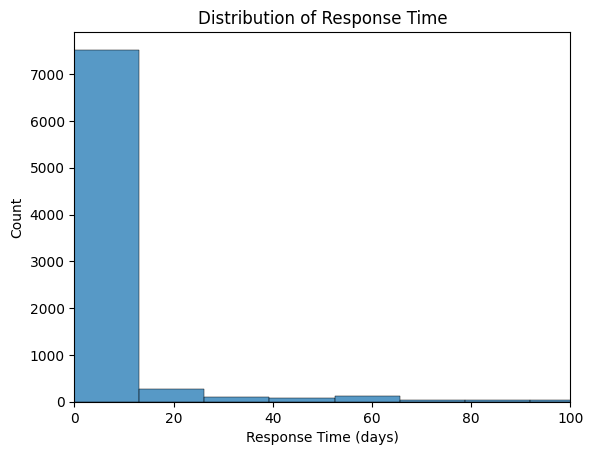

In [137]:
sns.histplot(df['response_time'].dt.days, bins=100)
plt.xlabel('Response Time (days)')
plt.title('Distribution of Response Time')
plt.xlim(0, 100) # limit x-axis to 100 days
plt.show()

In [138]:
# calculate mean response time by police precinct
precinct_response = df.groupby('precinct')['response_time'].mean().sort_values()

# convert to fractions of days for better readability
# will make the reponse time a float instead of datatime.timedelta
precinct_response_days = precinct_response.dt.total_seconds() / (24 * 3600)


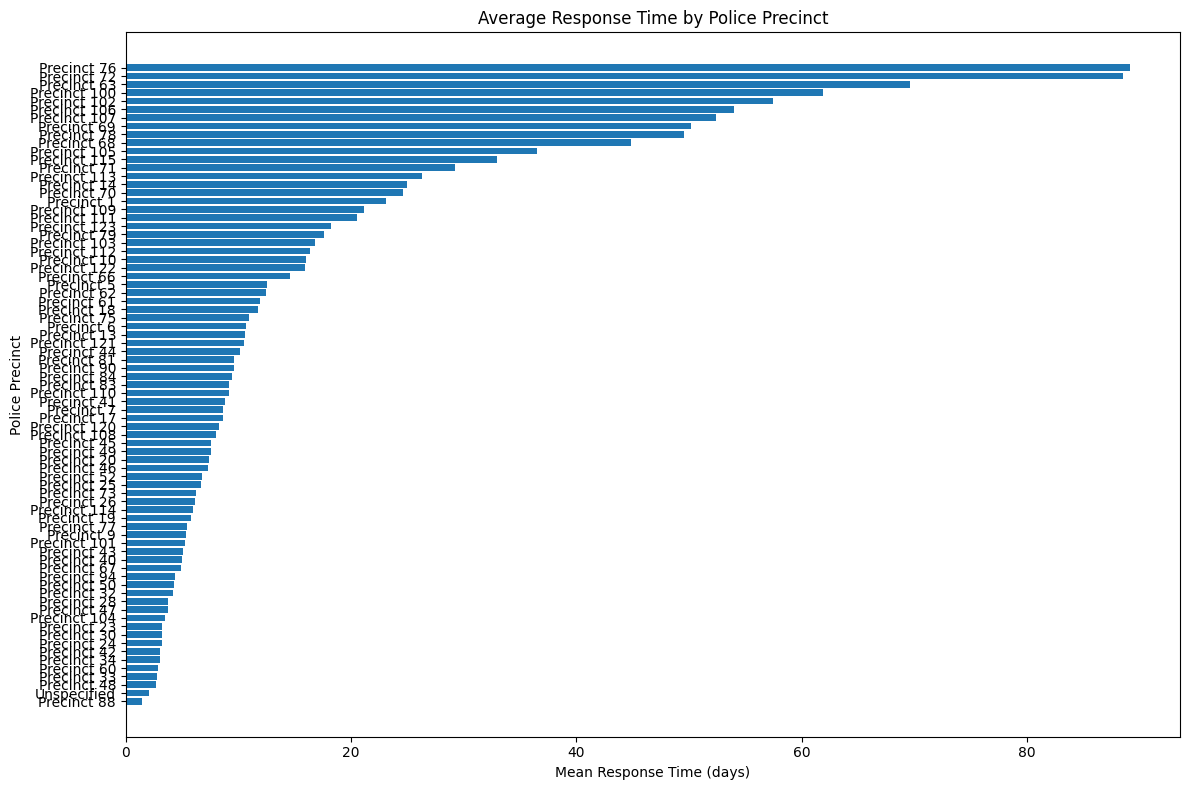

In [139]:
# create the plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(precinct_response_days)), precinct_response_days)
plt.yticks(range(len(precinct_response_days)), precinct_response_days.index)
plt.xlabel('Mean Response Time (days)')
plt.ylabel('Police Precinct')
plt.title('Average Response Time by Police Precinct')
plt.tight_layout()
plt.show()

In [140]:
# one-way ANOVA: response time by precinct
df['response_time_days'] = df['response_time'].dt.total_seconds() / (24 * 3600)
model = sm.formula.ols('response_time_days ~ C(precinct)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


                   sum_sq      df          F         PR(>F)
C(precinct)  3.680494e+06    76.0  15.520894  2.635077e-183
Residual     2.673970e+07  8570.0        NaN            NaN


That's a really tiny PR(>F), the ANOVA measure of significance. That means it's very unlikely that we'd see these differences between precinct response times due to chance. I wonder which precincts do the best and worst?

In [141]:
# precincts with longest and shortest mean response times
shortest = precinct_response_days.head(5)
longest = precinct_response_days.tail(5)

print("Shortest mean response times (days):")
print(shortest)

print("\nLongest mean response times (days):")
print(longest)

Shortest mean response times (days):
precinct
Precinct 88    1.409084
Unspecified    2.056165
Precinct 48    2.718435
Precinct 33    2.738759
Precinct 60    2.887795
Name: response_time, dtype: float64

Longest mean response times (days):
precinct
Precinct 102    57.498497
Precinct 100    61.900519
Precinct 63     69.609147
Precinct 72     88.559441
Precinct 76     89.143679
Name: response_time, dtype: float64


Maybe it's just because some precincts don't get very many 311 reports? To figure that out, we need to analyze data by precinct rather than by individual reports. So first we do some data transformation to get a dataframe where rows are precincts.

In [142]:
# volume of reports per precinct
precinct_volume = df['precinct'].value_counts().rename('report_count')

# combine with mean response time (days)
precinct_summary = pd.concat([precinct_response_days, precinct_volume], axis=1).dropna()

precinct_summary.head()

,response_time,report_count
precinct,,
Precinct 88,1.409084,62
Unspecified,2.056165,76
Precinct 48,2.718435,81
Precinct 33,2.738759,156
Precinct 60,2.887795,67


<Axes: xlabel='report_count', ylabel='response_time'>

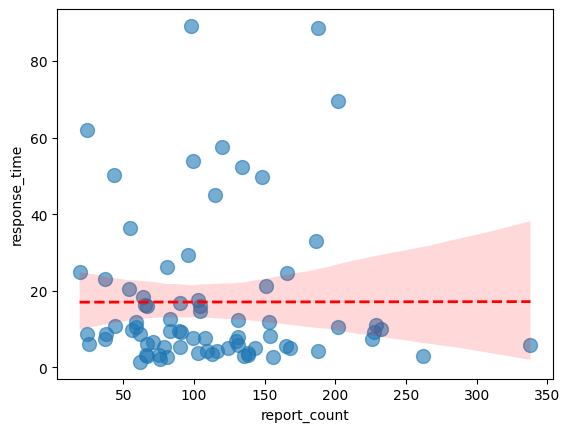

In [143]:
# regplot automatically adds regression line + confidence interval
sns.regplot(
    data=precinct_summary,
    x='report_count',
    y='response_time',
    ax=None,
    scatter_kws={'s': 100, 'alpha': 0.6},
    line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 2}
)


In [144]:
# correlation
corr = precinct_summary['report_count'].corr(precinct_summary['response_time'])
print(f"Correlation between report count and mean response time: {corr:.3f}")

Correlation between report count and mean response time: 0.001


In [145]:
# simple regression: response time ~ report count
volume_model = sm.formula.ols('response_time ~ report_count', data=precinct_summary.reset_index()).fit()
print(volume_model.summary())

                            OLS Regression Results                            
Dep. Variable:          response_time   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                 0.0001473
Date:                Wed, 18 Feb 2026   Prob (F-statistic):              0.990
Time:                        12:11:06   Log-Likelihood:                -337.99
No. Observations:                  77   AIC:                             680.0
Df Residuals:                      75   BIC:                             684.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       17.0049      4.722      3.601   

In [146]:
apa_report(volume_model)

'A linear regression was conducted to predict response_time from report_count. The regression equation was not statistically significant, F(1, 75) = 0.00, p = 0.990, with an R² of 0.00. The slope for report_count was 0.00 (SE = 0.04), t(75) = 0.01, p = 0.990.'

Huh. The volume of reports doesn't predict how long it'll take to resolve it. I wonder if reponse time is a function of the type of report?

In [147]:
# calculate a regression model with response_time_days as outcome and report_count and problem_type as predictors
# first need to merge report_count back to the main dataframe
df = df.merge(precinct_volume.reset_index(), left_on='precinct', right_on='precinct', how='left')

# fit the model
problem_volume_model = sm.formula.ols('response_time_days ~ report_count + C(problem_type)', data=df).fit()
print(problem_volume_model.summary())

                            OLS Regression Results                            
Dep. Variable:     response_time_days   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     65.25
Date:                Wed, 18 Feb 2026   Prob (F-statistic):               0.00
Time:                        12:11:07   Log-Likelihood:                -45046.
No. Observations:                8647   AIC:                         9.030e+04
Df Residuals:                    8542   BIC:                         9.104e+04
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

# AI Appendix

I used ChatGPT in Dia to help me resolve some errors.

## Converting Created Date and Closed Date to datetime
Prompt: 
```
    ValueError: time data "02/02/2026 11:42:52 PM" doesn't match format "%Y-%m-%d %H:%M:%S", at position 0. You might want to try:
        - passing `format` if your strings have a consistent format;
        - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
        - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.
```

Dia returned (in part):
```
You need a different format string for that new timestamp.

For the string `"02/02/2026 11:42:52 PM"`, the correct pandas/strftime format is:

`%m/%d/%Y %I:%M:%S %p`
```

So I used that pattern as the argument in my `pd.to_datetime` functions, and it ran without errors. I checked the calculation of `response_time` to make sure it worked.

## Plotting Precinct Response Times

I used a _Generate_ cell in VS Code. I prompted it with "plot response time by police precinct". It wrote some code for creating a precinct-level dataset. I divided that code into multiple cells and added comments to explain what it was doing. Then I checked the output, and it drew the histogram I expected.